# Scientific Programming in Python
## Final Project
## Jeelka Hessenius und Luca Saur
\
\
\
## Imports

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

## Data loading
### Moodnoodles Data

**Moodnoodles** is a website built by Luca that allows you to track wellbeing, habits and other things. It has been used daily by Jeelka and Luca for the past two months to generate the dataset we are using for this project. Please visit <https://moodnoodles.com> to familiarize yourself with the setup.

We have chosen a **subset** of our tracked data and exported it as csv file. In the following code block we load the data and refactor the complicated user_id for simplicity purposes so that now Luca's user_id is 0 and Jeelka's is 1.
### Clockify Data

Additionally, we track work time using Clockify. For their set-up check out <https://app.clockify.me/tracker>. In general, we make sure to track the minimal work-time possible such that short breaks etc. are not included. Even though in Clockify we track work-time per project, for this assignment we decided to export our data grouped by day. This is because we are interested in how our total work-time per day affected our well-being without considering the effect of working on specific projects.\

In the code block below we read in the data from our Clockify data set and select the relevant columns "Date" and "Time..decimal.". Converting the "Date" column into date format will later help us to join this dataframe onto our main data set.

In [37]:
# Load data
# wellbeing.csv containts the self reported data of two participants
df = pd.read_csv('data/wellbeing.csv')

# worktime_jeelka.csv and worktime_luca.csv contain the worktime data of the two participants
df_wt_0 = pd.read_csv('data/worktime_jeelka.csv')
df_wt_1 = pd.read_csv('data/worktime_luca.csv')

# drop User column because we user_id from wellbeing.csv later
df_wt_0.drop(columns=['User'], inplace=True)

# drop time (h) because we use time decimal
df_wt_0.drop(columns=['Time (h)'], inplace=True)
df_wt_1.drop(columns=['Time (h)'], inplace=True)

# Rename Date column to match date from wellbeing.csv and Time (decimal) to time
df_wt_0.rename(columns={'Date': 'date', 'Time (decimal)': 'time'}, inplace=True)
df_wt_1.rename(columns={'Date': 'date', 'Time (decimal)': 'time'}, inplace=True)

# convert all to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=False)
df_wt_0['date'] = pd.to_datetime(df_wt_0['date'], dayfirst=True)
df_wt_1['date'] = pd.to_datetime(df_wt_1['date'], dayfirst=True)

# convert uuid user_ids to binary (two people in this data set)
df['user_id'] = df['user_id'].apply(lambda x: 0 if x in "e0e084c5-2308-4080-b217-90d5875fa312" else 1)
df_0 = df[df['user_id'] == 0]
df_1 = df[df['user_id'] == 1]

# drop user_id in the dataframes, because it is implied by the dataframe used
df_0 = df_0.drop(columns=['user_id'])
df_1 = df_1.drop(columns=['user_id'])

# merge worktime and wellbeing data for each person
df_0 = df_0.merge(df_wt_0, on='date').reset_index(drop=True)
df_1 = df_1.merge(df_wt_1, on='date').reset_index(drop=True)

df_1

,date,wellbeing,meditated,sleep_time,did_sport,steps,sweets,walk,time,Amount (EUR)
0,2024-12-21,6,False,8.5,False,11000,NaN,NaN,7.30,1.48
1,2024-12-22,7,True,8.0,True,7000,NaN,NaN,2.03,NaN
2,2024-12-27,6,True,9.0,False,8700,True,True,3.42,NaN
3,2024-12-23,6,True,8.0,False,17000,NaN,NaN,3.96,NaN
4,2024-12-25,6,True,8.0,False,14000,True,True,5.02,NaN
5,2024-12-26,6,True,7.0,False,9500,True,True,1.81,NaN
6,2024-12-30,6,True,7.5,False,6000,True,True,0.39,6.88
7,2024-12-28,7,False,8.0,False,11000,True,True,2.53,NaN
8,2024-12-29,6,True,7.5,True,2000,True,False,0.38,6.66
9,2024-12-31,7,True,7.5,False,23000,True,True,2.95,49.46


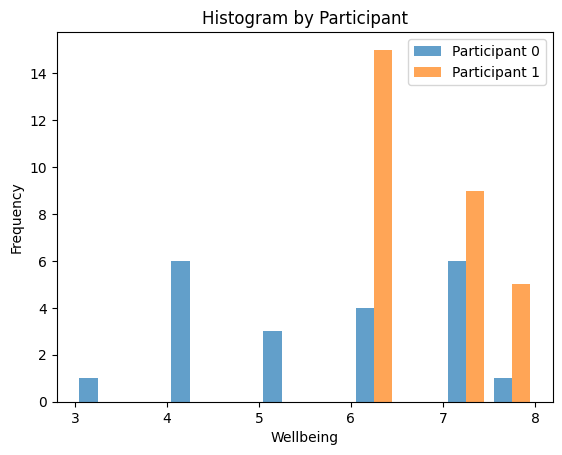

In [38]:
# Simple histogram to get a feeling for the wellbeing of each participant
plt.hist([df_0['wellbeing'], df_1['wellbeing']], bins=10, alpha=0.7, label=['Participant 0', 'Participant 1'])
plt.xlabel('Wellbeing')
plt.ylabel('Frequency')
plt.title('Histogram by Participant')
plt.legend()
plt.show()

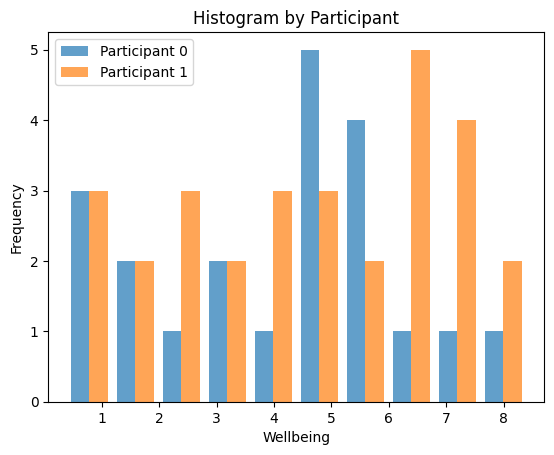

,date,wellbeing,meditated,sleep_time,did_sport,steps,sweets,walk,time,Amount (EUR)
date,1.000000,0.513929,0.364762,-1.415355e-01,0.612228,-0.161431,-4.909248e-01,0.237432,0.536526,0.554332
wellbeing,0.513929,1.000000,0.083641,-6.978269e-02,0.243610,0.235129,-1.252508e-01,0.212417,0.340125,0.491261
meditated,0.364762,0.083641,1.000000,-1.236957e-01,0.283315,-0.088005,-1.649572e-01,-0.047619,-0.058381,0.355051
sleep_time,-0.141535,-0.069783,-0.123696,1.000000e+00,-0.268677,-0.102134,7.502999e-16,0.166398,0.152095,0.002938
did_sport,0.612228,0.243610,0.283315,-2.686775e-01,1.000000,-0.269558,-3.779645e-01,-0.218218,0.245122,0.250765
steps,-0.161431,0.235129,-0.088005,-1.021337e-01,-0.269558,1.000000,-1.249400e-02,0.383278,0.052862,0.229195
sweets,-0.490925,-0.125251,-0.164957,7.502999e-16,-0.377964,-0.012494,1.000000e+00,-0.164957,-0.416272,-0.088738
walk,0.237432,0.212417,-0.047619,1.663984e-01,-0.218218,0.383278,-1.649572e-01,1.000000,0.380926,0.354225
time,0.536526,0.340125,-0.058381,1.520947e-01,0.245122,0.052862,-4.162716e-01,0.380926,1.000000,0.387940
Amount (EUR),0.554332,0.491261,0.355051,2.937728e-03,0.250765,0.229195,-8.873762e-02,0.354225,0.387940,1.000000


In [39]:
# Simple histogram to get a feeling for the wellbeing of each participant
plt.hist([df_0['time'], df_1['time']], bins=10, alpha=0.7, label=['Participant 0', 'Participant 1'])
plt.xlabel('Wellbeing')
plt.ylabel('Frequency')
plt.title('Histogram by Participant')
plt.legend()
plt.show()

df_1.corr()

From the correlation matrix, we can see that date, work_time, walk, did_sport, sweets time have some correlation with wellbeing.
But overall, the correlation is not very strong. Furthermore, the data is not very dense, so it is difficult to make any conclusions.

In [40]:
plt.scatter(df_0['time'], df_0['wellbeing'])
plt.scatter(df_1['time'], df_1['wellbeing'])

### Lets try to predict wellbeing with a neural network

In [41]:
# Process the data for the neural network  
df_all = pd.concat([df_0, df_1])
df_all.reset_index(drop=True, inplace=True)
# Fill NaN values with False
df_all.fillna(False, inplace=True)

# Select the features and the target
# Features: meditated, sleep_time, did_sport, steps, sweets, walk, time
# Target: wellbeing

X = df_all[['sleep_time', 'time', 'sweets', 'meditated', 'did_sport', 'walk']]
X = X.astype({'meditated': int, 'did_sport': int, 'walk': int, 'sweets': int})  # Convert boolean columns

y = df_all['wellbeing']

scaler = StandardScaler()
X.iloc[:, :2] = scaler.fit_transform(X.iloc[:, :2])  # Use .iloc for column selection

X = X.to_numpy()
y = y.to_numpy()

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split the data into training and test set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

/tmp/ipykernel_5108/166198665.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all.fillna(False, inplace=True)
/tmp/ipykernel_5108/166198665.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_all.fillna(False, inplace=True)


In [42]:
# Function to draw the neural network
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, model, loss):
    ax.axis('off')

    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Retrieve weights from the model
    weight = model.linear_relu_stack[0].weight.detach().numpy()

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        max_weight = np.max(np.abs(weight)) if n == 0 else 1  # Scale based on input weights if available
        for m in range(layer_size):
            size = v_spacing / 4. * (np.abs(weight[0, m]) / max_weight + 0.1) if n == 0 else v_spacing / 4.
            color = get_color_for_loss(loss) if n == len(layer_sizes) - 1 else 'w'
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), size, color=color, ec='k', zorder=4)
            ax.add_artist(circle)

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                x_coords = [n * h_spacing + left, (n + 1) * h_spacing + left]
                y_coords = [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing]
                line = plt.Line2D(x_coords, y_coords, c='k')
                ax.add_artist(line)
                # Display weight
                if n == 0:
                    ax.text((x_coords[0] + x_coords[1]) / 2, (y_coords[0] + y_coords[1]) / 2 + 0.02,
                            f"{weight[0, m]:.2f}", fontsize=16, va='center', ha='center', color='blue')

    plt.draw()


# Function to map loss to color
def get_color_for_loss(loss):
    if 25 < loss <= 50:
        return 'red'
    elif 15 < loss <= 25:
        return 'orange'
    elif 7 < loss <= 15:
        return 'yellow'
    else:  # 0 < loss <= 7
        return 'green'

### finally, lets train and test the model

Epoch 10, Loss: 32.7927
Epoch 20, Loss: 29.0217
Epoch 30, Loss: 25.6379
Epoch 40, Loss: 22.6312
Epoch 50, Loss: 19.9712
Epoch 60, Loss: 17.6224
Epoch 70, Loss: 15.5521
Epoch 80, Loss: 13.7327
Epoch 90, Loss: 12.1396
Epoch 100, Loss: 10.7508
R-squared Score: -4.8656
Mean Absolute Error: 2.7006
Relative Error: 0.4365

Test Loss: 8.7398
Sample Prediction: 4.4363
Sample True Value: 6.0000
Parameter containing:
tensor([[ 5.2819e-01, -4.2476e-04,  5.5961e-01,  1.2239e+00,  9.4243e-01,
          1.1664e+00]], requires_grad=True)


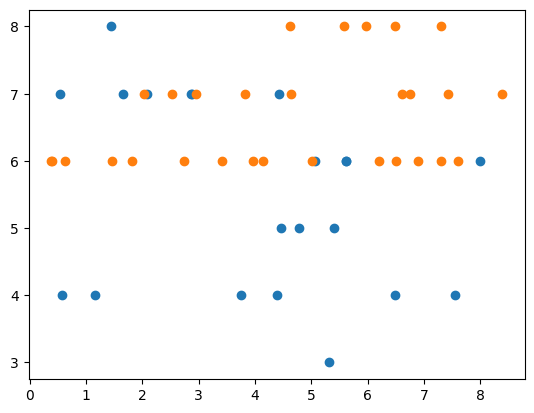

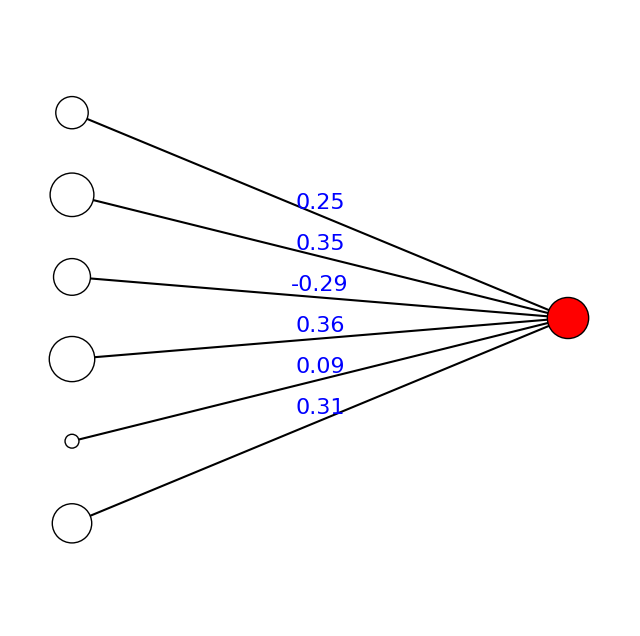

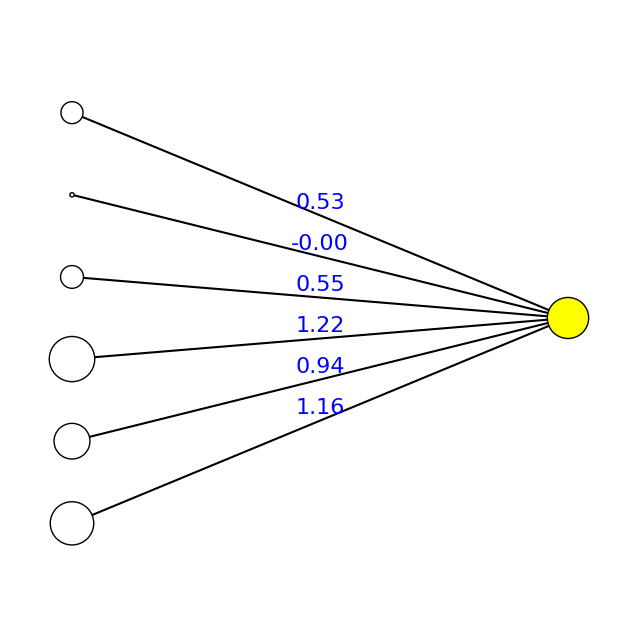

In [43]:
INPUT_LAYER_SIZE = 6
OUTPUT_LAYER_SIZE = 1

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(INPUT_LAYER_SIZE, OUTPUT_LAYER_SIZE),
            # nn.ReLU(),
            # nn.Linear(6, 1),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
        
net = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)



# For plotting the nn
plt.ion()  # Enable interactive mode
fig1, ax1 = plt.subplots(figsize=(8, 8))
fig2, ax2 = plt.subplots(figsize=(8, 8))
layer_sizes = [INPUT_LAYER_SIZE, OUTPUT_LAYER_SIZE]


# Train the network
for epoch in range(100):
    if epoch == 1:
        #draw the net
        draw_neural_net(ax1, .1, .9, .1, .9, layer_sizes, net, loss.item())
        time.sleep(1)
    if epoch == 99:
        #draw the net
        draw_neural_net(ax2, .1, .9, .1, .9, layer_sizes, net, loss.item())
        time.sleep(1)
    optimizer.zero_grad()
    outputs = net(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


plt.ioff()

# Test and evaluate the network
with torch.no_grad():
    test_outputs = net(X_test)
    test_loss = criterion(test_outputs, y_test)
    
    y_pred = test_outputs.detach().numpy()
    y_true = y_test.numpy()

    # Compute R²
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))

    # Relative Error (RE) - with division safety
    re = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8)))

    print(f"R-squared Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Relative Error: {re:.4f}")

    

print(f"\nTest Loss: {test_loss.item():.4f}")

print(f"Sample Prediction: {test_outputs[0].item():.4f}")
print(f"Sample True Value: {y_test[0].item():.4f}")

# If we use a single linear layer, we can recover the parameters from the network
print(net.linear_relu_stack[0].weight)


# example tensor([[0.5257, 0.1423, 1.1832, 0.9429, 0.6883, 0.9817]], requires_grad=True)
# could compare this to the correlation matrix to see if the model is able to recover the parameters
# but we have a REEEALLLY high error so ....

As we can see, the model is not very good at predicting the wellbeing of the participants.
To be exact, the model is a lot worse then simply calculating the mean of the wellbeing of the participants.

This is to be expected, because we have few and sparse data. Furthermore, there are two participants and we have time series data, which is not factored into the model.

But it was a fun exercise to try to predict wellbeing with a neural network.

### Lets try to predict wellbeing with a simple linear regression model

Coefficient (slope): 0.0956
Intercept: 6.1948
R-squared Score: 0.2520


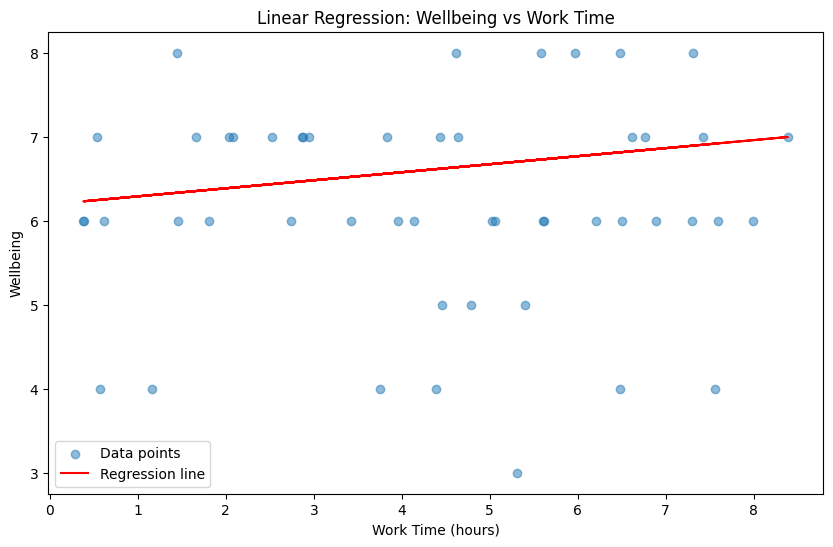

In [44]:
# Create simple linear regression model using only the 'time' feature
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare the data (using only 'time' as feature)
X_time = df_1[['time']].values
y = df_1['wellbeing'].values

# Split the data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_time, y, test_size=0.2, random_state=42
)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Visualize the regression line
plt.figure(figsize=(10, 6))
plt.scatter(df_all['time'], df_all['wellbeing'], alpha=0.5, label='Data points')
plt.plot(X_time, model.predict(X_time), color='red', label='Regression line')
plt.xlabel('Work Time (hours)')
plt.ylabel('Wellbeing')
plt.title('Linear Regression: Wellbeing vs Work Time')
plt.legend()
plt.show()



### Training a nn on surrogate data
#### To see if the nn is able to recover the parameters from the surrogate data and to see if our approach works in principle


In [45]:
### Lets create some surrogate data and train a nn on it, because we have so little data

np.random.seed(42)
torch.manual_seed(42)  # Set a random seed for PyTorch
num_features = 6
boolean_features = 0
total_features = num_features + boolean_features

# Create a simple function to generate surrogate data
def generate_surrogate_data(n_samples=50, n_num_features=6, n_boolean_features=0):
    """
    Generate surrogate data with random correlations between features.
    """
    total_features = n_num_features + n_boolean_features
    # Generate random weights for each feature
    weights = np.random.uniform(-1, 1, total_features)
    print("original weights", weights)
    # Generate random data
    boolean_data = np.random.randint(0, 2, (n_samples, n_boolean_features))
    num_data = np.random.randn(n_samples, n_num_features)
    data = np.concatenate([boolean_data, num_data], axis=1)
    # Calculate the target as a linear combination of the features
    target = np.dot(data, weights) 
    return data, target

# Generate surrogate data
data, target = generate_surrogate_data(n_num_features=num_features, n_boolean_features=boolean_features)

# Split the data into training and test set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Train a neural network on the surrogate data
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(total_features, 1),
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

net = Net2()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
    # print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

with torch.no_grad():
    test_outputs = net(X_test_tensor)
    test_loss = loss_fn(test_outputs, y_test_tensor)
    
    y_pred = test_outputs.detach().numpy()  # Proper tensor conversion
    y_true = y_test_tensor.numpy()  # Ensure y_test is also NumPy

    # Compute R²
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))

    # Relative Error (RE) - with division safety
    re = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8)))

    print(f"R-squared Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Relative Error: {re:.4f}")

print("recovered weights")
print(net.linear_relu_stack[0].weight)
print()

print("error")
print(test_loss.item())
print(r2)

original weights [-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096]
R-squared Score: 0.9941
Mean Absolute Error: 0.0806
Relative Error: 0.0624
recovered weights
Parameter containing:
tensor([[-0.2440,  0.8934,  0.4376,  0.1920, -0.6808, -0.6073]],
       requires_grad=True)

error
0.010096751153469086
0.99412614


As we can see, the nn is able to recover the parameters from the surrogate data with a high accuracy.
Furthmore the error is very low, which is good. Even with a low number of samples (50), the nn is able to recover the parameters quite well.

To be fair, the data is very simple and only has this linear relationship, so it is not surprising that the nn is able to recover the parameters.


# Wordcloud from gratitude notes

[nltk_data] Downloading package punkt_tab to /home/jeelka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


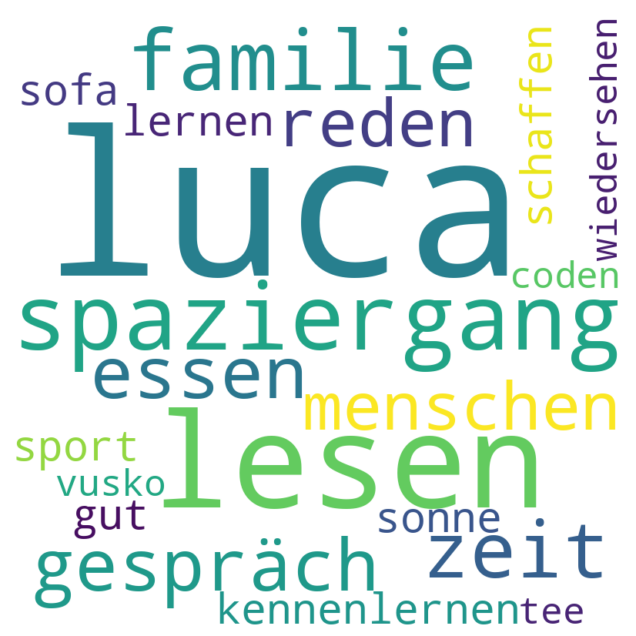

In [46]:
import nltk
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('punkt_tab')

# Start with defining all functions for pre-processing
def rm_special_char(text):
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'[^a-z^ä^ü^ö^ß^é(\s]', '', text) #using regex to remove all characters that are non-numeric and not a lower case letter and not a space by replacing with ''
    text = re.sub(r'lucas', 'luca', text)
    text = text.strip()
    return text

def tokenize(text):
    text = nltk.word_tokenize(text)
    return text

def rm_stopwords(text):
    stop_words = stopwords.words('german')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(['beim', 'denen', 'viele', 'nan', 'e', 'al', 'wa', 'aufm', 'nice', 'good', 'lot', 'cool', 'much'])
    text_without_stopwords = [word for word in text if word not in stop_words]
    return text_without_stopwords

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(text)):
        text[i] = lemmatizer.lemmatize(text[i], pos='n') #lemmatizing as noun
        text[i] = lemmatizer.lemmatize(text[i], pos='v') #lemmatizing as verb (if no corresponding form is found, the word remains unchanged)
    return text

def preprocess(text):
    text = str(text)
    text = text.lower()
    text = rm_special_char(text)
    text = tokenize(text)
    text = lemmatize(text)
    text = rm_stopwords(text)
    return text


def wordcloud_words(word_counts, num_words_to_diagram = 20):
    word_counts_top_words = word_counts[:num_words_to_diagram]
    # Create a dictionary that maps words to their frequencies
    word_count_dict = {word: count for word, count in word_counts_top_words}

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=800, background_color='white')

    # Generate the word cloud
    wordcloud.generate_from_frequencies(word_count_dict)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')

    plt.axis("off")
    plt.show()

df = pd.read_csv('data/gratitude_entries-2025-02-17_jeelka.csv')

preprocessed_entries = [preprocess(entry) for entry in df[('gratitude')]]
preprocessed_entries_flat = [word for lst in preprocessed_entries for word in lst]
word_count = nltk.FreqDist(preprocessed_entries_flat)
word_count_top_words = word_count.most_common(1000)
# barchart_words(word_count_top_words, 20)
wordcloud_words(word_count_top_words, 20)